In [372]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [373]:
df = pd.read_csv('datasets/dataset_train.csv')[['Hogwarts House', 'Herbology', 'Defense Against the Dark Arts',
       'Divination', 'Muggle Studies', 'Ancient Runes', 'History of Magic',
       'Transfiguration', 'Care of Magical Creatures', 'Charms', 'Flying']]
df.head()

,Hogwarts House,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Care of Magical Creatures,Charms,Flying
0,Ravenclaw,5.727180,4.878861,4.722,272.035831,532.484226,5.231058,1039.788281,0.715939,-232.79405,-26.89
1,Slytherin,-5.987446,5.520605,-5.612,-487.340557,367.760303,4.107170,1058.944592,0.091674,-252.18425,-113.45
2,Ravenclaw,7.725017,3.660761,6.140,664.893521,602.585284,3.555579,1088.088348,-0.515327,-227.34265,30.42
3,Gryffindor,-6.497214,-6.977428,4.026,-537.001128,523.982133,-4.809637,920.391449,-0.014040,-256.84675,200.64
4,Gryffindor,-7.820623,NaN,2.236,-444.262537,599.324514,-3.444377,937.434724,-0.264070,-256.38730,157.98


In [374]:
# for train: Ravenclaw -> Slytherin -> Gryffindor
df = df[['Hogwarts House', 'Muggle Studies', 'Charms', 'Divination', 'Flying', 'History of Magic', 'Transfiguration']]
df.head()

,Hogwarts House,Muggle Studies,Charms,Divination,Flying,History of Magic,Transfiguration
0,Ravenclaw,272.035831,-232.79405,4.722,-26.89,5.231058,1039.788281
1,Slytherin,-487.340557,-252.18425,-5.612,-113.45,4.107170,1058.944592
2,Ravenclaw,664.893521,-227.34265,6.140,30.42,3.555579,1088.088348
3,Gryffindor,-537.001128,-256.84675,4.026,200.64,-4.809637,920.391449
4,Gryffindor,-444.262537,-256.38730,2.236,157.98,-3.444377,937.434724


In [375]:
df.shape[0]

1600

In [376]:
df.shape[0] - df.dropna().shape[0]

148

In [377]:
df = df.dropna()

In [378]:
df.shape

(1452, 7)

In [379]:
div = 0.9
df_test = df.iloc[int(df.shape[0] * div):]
df = df.iloc[:int(df.shape[0] * div)]
df.shape

(1306, 7)

In [380]:
def get_minmax(x):
    x_minmax = np.zeros([x.shape[1], 2], np.float32)
    for i in range(x.shape[1]):
        x_minmax[i] = [x[:, i].min(), x[:, i].max()]
    return x_minmax

def normalization(target, val_min, val_max):
    return (target - val_min) / (val_max - val_min)

def set_xnorm(x, x_minmax):
    for i in range(x.shape[1]):
        x[:, i] = normalization(x[:, i], *x_minmax[i])

y = df.values[:, 0]
x = df.values[:, 1:].astype(np.float32)
x_minmax = get_minmax(x)
set_xnorm(x, x_minmax)
bias = np.ones((x.shape[0], 1))
x = np.concatenate((x, bias), 1)

In [381]:
def sigmoid(predict):
    sigmoid = 1 / (1 + np.exp(-predict))
    return sigmoid

# def loss_log(y, predict):
#     loss_log = -np.mean(y * np.log(predict) +
#                         (1 - y) * np.log(1 - predict))
#     return loss_log

def loss_log(predict, y, target):

    y =  np.array(list(map(lambda x: 1 if x == target else 0, y)))
    # if target == 'Ravenclaw':
    #     y =  np.array(list(map(lambda x: 1 if x == target else 0, y)))
    # else:
    #     y =  np.array(list(map(lambda x: 0 if x == target else 1, y)))

    loss_log = -np.mean(y * np.log(predict) +
                        (1 - y) * np.log(1 - predict))
    return loss_log

In [382]:
weight = np.random.random(x.shape[1] + 2)
delta = np.zeros(weight.size, np.float32)
# alpha = np.array([0.01] * weight.size, np.float32) #maybe change to scalar
alpha = 0.01
epochs = 200
error = np.zeros([epochs, 3], np.float32)
for j in range(epochs):

    predict_r = sigmoid(np.concatenate([x[:, 0:2],
                                        x[:, -1].reshape(-1, 1)],
                                    axis=1) @ weight[0:3])
    
    predict_s = sigmoid(np.concatenate([x[:, 2:4],
                                        x[:, -1].reshape(-1, 1)],
                                    axis=1) @ weight[3:6])

    predict_g = sigmoid(np.concatenate([x[:, 4:6],
                                        x[:, -1].reshape(-1, 1)],
                                    axis=1) @ weight[6:9])

    error[j][0] = loss_log(predict_r, y, 'Ravenclaw')
    error[j][1] = loss_log(predict_s, y, 'Slytherin')
    error[j][2] = loss_log(predict_g, y, 'Gryffindor')


    for i in range(x.shape[0]):

        predict_r = sigmoid(np.concatenate([x[i][0:2],
                                    [x[i][-1]]]) @ weight[0:3])

        delta[0:3] += (predict_r - int(y[i] == 'Ravenclaw')) *\
                        (predict_r * (1 - predict_r)) *\
                        np.concatenate([x[i][0:2], [x[i][-1]]])


        predict_s = sigmoid(np.concatenate([x[i][2:4],
                                    [x[i][-1]]]) @ weight[3:6])

        delta[3:6] += (predict_s - int(y[i] == 'Slytherin')) *\
                        (predict_s * (1 - predict_s)) *\
                        np.concatenate([x[i][2:4], [x[i][-1]]])


        predict_g = sigmoid(np.concatenate([x[i][4:6],
                                    [x[i][-1]]]) @ weight[6:9])

        delta[6:9] += (predict_g - int(y[i] == 'Gryffindor')) *\
                        (predict_g * (1 - predict_g)) *\
                        np.concatenate([x[i][4:6], [x[i][-1]]])
    
    weight -= delta * alpha
    delta[:] = 0


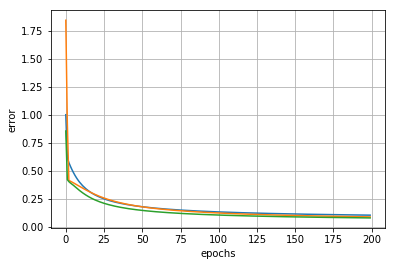

In [383]:
# plt.plot(range(epochs), error[:, 0])
plt.plot(range(epochs), error)
plt.xlabel('epochs')
plt.ylabel('error')
plt.grid()
plt.show()

In [384]:
error[-1]

array([0.10197134, 0.08661171, 0.07726491], dtype=float32)

In [385]:
weight

array([ 5.85038559,  5.57879639, -6.6708094 , -8.42057268, -2.4384794 ,
        4.25756981, -5.42423768, -5.63848767,  4.57222868])

In [386]:
df_test.head(20)

,Hogwarts House,Muggle Studies,Charms,Divination,Flying,History of Magic,Transfiguration
1437,Gryffindor,-670.368577,-254.67808,5.109,246.76,-7.545058,928.476711
1438,Hufflepuff,-495.832714,-244.13536,5.286,26.88,4.153129,1043.578570
1439,Hufflepuff,-602.548895,-245.04629,4.562,-51.42,4.658685,1060.349507
1440,Gryffindor,-466.889352,-251.92547,5.857,227.01,-6.312408,944.991478
1441,Slytherin,-840.602433,-248.78562,-4.861,-99.87,6.083082,1071.843317
1443,Gryffindor,-510.491761,-255.12874,3.526,153.59,-3.690399,946.706549
1444,Slytherin,799.658514,-228.39853,6.955,-7.29,3.671743,1084.864485
1445,Gryffindor,-1040.739017,-255.42549,1.734,225.00,-6.810648,953.199757
1446,Gryffindor,-834.202775,-243.72415,6.217,-31.21,3.244444,1078.451414
1447,Slytherin,-565.091120,-251.22853,-5.022,-98.27,5.295359,1053.462465


In [512]:
string = 1437
ins = df_test.loc[string].values[1:].astype(np.float32)
ins
# np.concatenate([ins[0:2], [1]])

array([-670.3686  , -254.67809 ,    5.109   ,  246.76    ,   -7.545058,
        928.4767  ], dtype=float32)

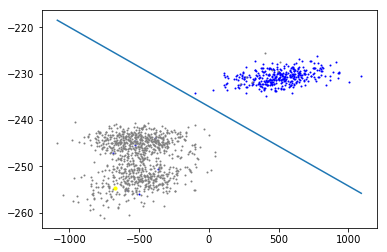

In [513]:
plt.scatter(df[df['Hogwarts House'] == 'Ravenclaw']['Muggle Studies'], df[df['Hogwarts House'] == 'Ravenclaw']['Charms'], color='blue', s=1)
plt.scatter(df[df['Hogwarts House'] != 'Ravenclaw']['Muggle Studies'], df[df['Hogwarts House'] != 'Ravenclaw']['Charms'], color='gray', s=1)

divider_x0 = x_minmax[0]
divider_x1 = -(normalization(x_minmax[0], *x_minmax[0]) * weight[0] + weight[2]) / weight[1]
divider_x1 = divider_x1 * (x_minmax[1][1] - x_minmax[1][0]) + x_minmax[1][0]
plt.plot(divider_x0, divider_x1)

plt.scatter(ins[0], ins[1], color='yellow', s=10)

plt.show()

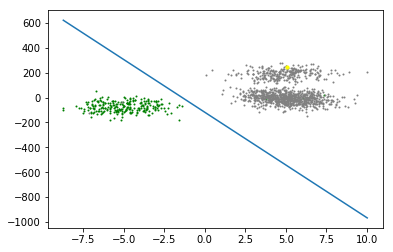

In [514]:
plt.scatter(df[df['Hogwarts House'] == 'Slytherin']['Divination'], df[df['Hogwarts House'] == 'Slytherin']['Flying'], color='green', s=1)
plt.scatter(df[df['Hogwarts House'] != 'Slytherin']['Divination'], df[df['Hogwarts House'] != 'Slytherin']['Flying'], color='gray', s=1)

divider_x0 = x_minmax[2]
divider_x1 = -(normalization(x_minmax[2], *x_minmax[2]) * weight[3] + weight[5]) / weight[4]
divider_x1 = divider_x1 * (x_minmax[3][1] - x_minmax[3][0]) + x_minmax[3][0]
plt.plot(divider_x0, divider_x1)

plt.scatter(ins[2], ins[3], color='yellow', s=10)

plt.show()

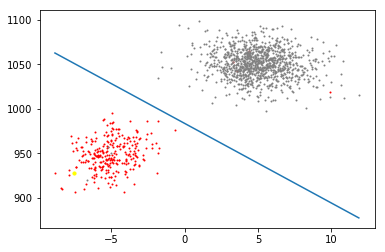

In [515]:
plt.scatter(df[df['Hogwarts House'] == 'Gryffindor']['History of Magic'], df[df['Hogwarts House'] == 'Gryffindor']['Transfiguration'], color='red', s=1)
plt.scatter(df[df['Hogwarts House'] != 'Gryffindor']['History of Magic'], df[df['Hogwarts House'] != 'Gryffindor']['Transfiguration'], color='gray', s=1)

divider_x0 = x_minmax[4]
divider_x1 = -(normalization(x_minmax[4], *x_minmax[4]) * weight[6] + weight[8]) / weight[7]
divider_x1 = divider_x1 * (x_minmax[5][1] - x_minmax[5][0]) + x_minmax[5][0]
plt.plot(divider_x0, divider_x1)

plt.scatter(ins[4], ins[5], color='yellow', s=10)

plt.show()

In [516]:
ins[0] = normalization(ins[0], *x_minmax[0])
ins[1] = normalization(ins[1], *x_minmax[1])
ins[2] = normalization(ins[2], *x_minmax[2])
ins[3] = normalization(ins[3], *x_minmax[3])
ins[4] = normalization(ins[4], *x_minmax[4])
ins[5] = normalization(ins[5], *x_minmax[5])
# ins = normalization(ins, *x_minmax)

In [517]:
probability_r = sigmoid(np.concatenate([ins[0:2], [1]]) @ weight[0:3])
probability_r

0.010397756745513392

In [518]:
probability_s = sigmoid(np.concatenate([ins[2:4], [1]]) @ weight[3:6])
probability_s


0.014477700125823716

In [519]:
probability_g = sigmoid(np.concatenate([ins[4:6], [1]]) @ weight[6:9])
probability_g

0.9730953732832806